In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
from astropy.io import fits
import os
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns
import numpy as np

from snclassification import data, model, utils, fitting, plotting
from snclassification.fitting import Fitting, FittingValues, FittingValuesList, ParamProperties

%matplotlib inline

plt.rcParams['text.usetex'] = True
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('ggplot')
plt.style.use(['bmh', 'dark_background'])
# plt.style.use(['dark_background'])

In [195]:
# Raw data
data_folder_path = 'data/data_180528'
dir_names = ['GRB', 'SLSN', 'sn']

# Transient types to include
transient_types = {'GRB', 'SLSN-IIn', 'SLSN-I', 'SNIc', 'SNIb', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIbn', 'SNIIb'}

# Refined data
transient_types_folder_path = 'transient_types'

# Read data

In [196]:
full_cat_table = data.load_cat_table(data_folder_path, dir_names)

## Filter data

**Filter N/A**

In [197]:
full_cat_table = full_cat_table.dropna()

**Filter by redshift**

Consider only $z < 1$

In [198]:
full_cat_table = full_cat_table[full_cat_table.REDSHIFT < 1]

**Filter by transient type**

Consider only the following transient types: <br>
{{', '.join(transient_types)}}

In [199]:
full_cat_table = full_cat_table[full_cat_table.TYPE.isin(transient_types)]

## Group by transient types

In [200]:
cat_table_dict = data.create_cat_table_dict(full_cat_table)

transient_type_dict = data.load_all_objects_by_transient_type(
    cat_table_dict, data_folder_path, transient_types_folder_path)

Loading "SNIIb"... (39 objects)
Loading "SNIb"... (34 objects)
Loading "SNIc"... (44 objects)
Loading "SNII"... (356 objects)
Loading "SNIIn"... (67 objects)
Loading "SLSN-IIn"... (29 objects)
Loading "GRB"... (27 objects)
Loading "SNIc-BL"... (21 objects)
Loading "SLSN-I"... (66 objects)
Loading "SNIbn"... (7 objects)
Done.


In [201]:
transient_type_dict.values()[0].head()

,object_id,probability,ln_likelihood,mass,redshift,tauV_eff,tau,metallicity,sfr
0,PTF09dah,4.916615e-07,-34.536079,9.220975,0.0238,0.061908,10.401312,-1.300038,-1.641671
1,PTF09dah,4.963811e-07,-34.519859,9.238229,0.0238,0.074234,10.294583,-1.299876,-2.266136
2,PTF09dah,5.154411e-07,-34.475513,9.383832,0.0238,1.072930,10.373243,-1.976385,-0.673781
3,PTF09dah,6.747860e-07,-34.199474,9.286065,0.0238,0.675002,10.402370,-1.730701,-2.416761
4,PTF09dah,6.869340e-07,-34.174965,9.708236,0.0238,0.221802,8.324946,-1.257869,-0.303323


---

# Analysis

## Redshift histograms

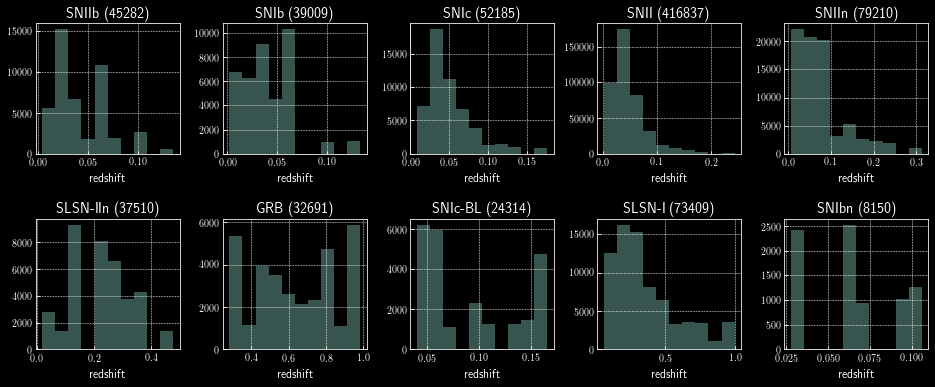

In [202]:
plotting.plot_redshift_histograms(transient_type_dict)

## Mass histograms

**Weighted mean mass of an object**

Calculate the mean mass of an object by weighting each mass (of different model realizations) with the probability of the realization.

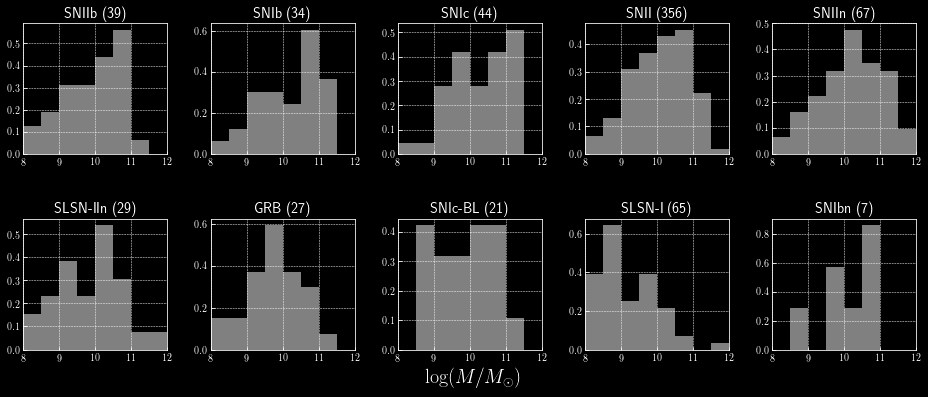

In [204]:
plotting.plot_weighted_mass_histograms(transient_type_dict, bins=fitting.BINS)
# plotting.plot_weighted_mass_histograms(transient_type_dict, bins=fitting.BINS, save_to_file = 'nb_figures/mass_histograms.svg')

# General population of star-forming galaxies

In [205]:
log_M_range = data.LOG_M_RANGE

## Mass function

### Best-fit Schechter function Parameters

**Tomczak**

Table 2 from Tomczak et al. (2014)
http://iopscience.iop.org/article/10.1088/0004-637X/783/2/85/pdf

In [206]:
# Table 2 from Tomczak's papar
tomczak_table_file_path = 'data/tomczak_2014_table2_ascii.txt'

tomczak_parameters = model.schechter_parameters_from_tomczak(tomczak_table_file_path)
tomczak_parameters

,Redshift_from,Redshift_to,log(M),log(phi_1),alpha_1,log(phi_2),alpha_2
0,0.20,0.50,10.59,-2.67,-1.08,-4.46,-2.00
1,0.50,0.75,10.65,-2.97,-0.97,-3.34,-1.58
2,0.75,1.00,10.56,-2.81,-0.46,-3.36,-1.61


**Muzzin**

Table 1 from Muzzin (2013)
http://iopscience.iop.org/article/10.1088/0004-637X/777/1/18/pdf

In [207]:
# Table 1 from Muzzin's papar
muzzin_2013_table1_ascii = 'data/muzzin_2013_table1_ascii.txt'

muzzin_parameters = model.schechter_parameters_from_muzzin(muzzin_2013_table1_ascii)
muzzin_parameters

,Redshift_from,Redshift_to,log(M),log(phi_1),alpha_1,log(phi_2),alpha_2
7,0.2,0.5,10.81,-2.945004,-1.34,-inf,0
14,0.5,1.0,10.78,-2.895854,-1.26,-inf,0


### Evaluating the Schechter function

In [208]:
### Double-Schechter function (Tomczak)
# phi_dict = model.evaluate_double_schecter_functions(tomczak_parameters)

### Single-Schechter function (Muzzin)
phi_dict = model.evaluate_single_schecter_functions(muzzin_parameters)

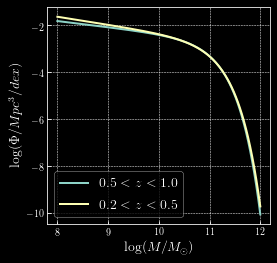

In [209]:
plt.figure(figsize=(4, 4))
for (z_from, z_to), phi_func in phi_dict.iteritems():
    plt.plot(log_M_range, np.log10(phi_func(log_M_range)), label='${} < z < {}$'.format(z_from, z_to))
# plt.plot(log_M_range, np.log10(phi_dict[(0.2, 0.5)](log_M_range)), label='Single-Schecter')
plt.xlabel('$\log({M / M_{\odot}})$', fontsize=14)
plt.ylabel('$\log({\Phi / Mpc^3 / dex})$', fontsize=14)
plt.legend(fontsize=14)
# plt.savefig('nb_figures/single_schecter.svg', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

## Star formation (galaxy main-sequence)
Whitaker (2014) http://iopscience.iop.org/article/10.1088/2041-8205/754/2/L29/pdf

$\log (SFR) = \alpha(z)(\log ({M_\star}) - 10.5) + \beta(z)$<br>
*where*<br>
$\alpha(z) = 0.70 - 0.13z$<br>
$\beta(z) = 0.38 + 1.14z - 0.19z^2$

In [211]:
log_SFR_func = model.generate_log_SFR_func()

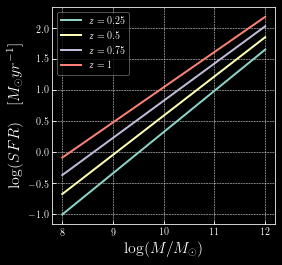

In [212]:
plt.figure(figsize=(4, 4))
for z in [0.25, 0.5, 0.75, 1]:
    plt.plot(log_M_range, log_SFR_func(log_M_range, z), label='$z=%s$' % z)
plt.xlabel('$\log ({M/M_{\odot}})$', fontsize=16)
plt.ylabel('$\log (SFR)\quad [M_{\odot} yr^{-1}]$', fontsize=16)
plt.legend()
# plt.savefig('nb_figures/SFR.svg', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

## Mass function weighted by SFR
Weighting the mass function with the SFR of each mass, using the galaxy main-sequence.

In [213]:
mass_function_SFR = model.generate_mass_function_SFR(phi_dict, 0.2)

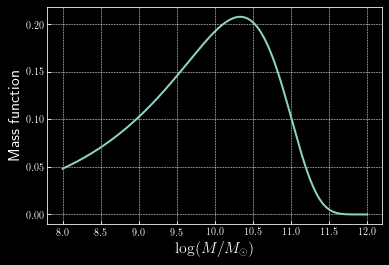

In [214]:
plt.figure(figsize=(6, 4))

# sns.distplot(utils.calculate_object_mean_mass(transient_type_dict['SNII']), 
#              kde=True, norm_hist=False, rug=True, hist_kws={'histtype': 'step', 'linewidth': 3})

plt.plot(log_M_range, mass_function_SFR(log_M_range))

plt.xlabel('$\log (M/M_{\odot})$', fontsize=16)
plt.ylabel('Mass function', fontsize=16)
# plt.savefig('nb_figures/mass_function.svg', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

**Bin centers with the mass function**

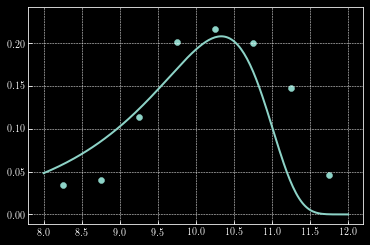

In [215]:
df = transient_type_dict['SNIIn']
bin_centers, bin_heights = fitting.calculate_bin_coordinates(df.mass)

plt.figure()
plt.scatter(bin_centers, bin_heights)
plt.plot(log_M_range, mass_function_SFR(log_M_range))
plt.show()

**Comparison to mass histograms**

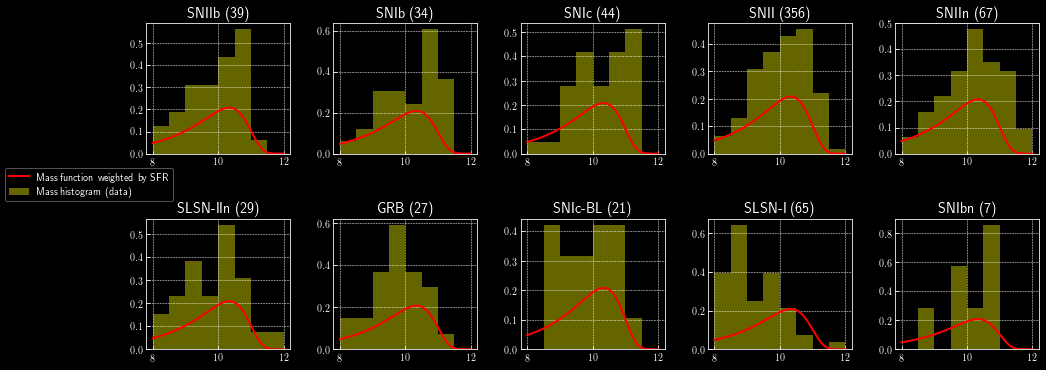

In [216]:
plotting.plot_weighted_mass_histograms_and_mass_function_SFR(
    transient_type_dict, fitting.BINS, mass_function_SFR, log_M_range)

# SFR efficiency

## Efficiency function $\rho(M)$

In [217]:
rho_func = np.vectorize(lambda M, M0, beta, C: C*np.exp(-(M/M0)**beta))
# rho_func = np.vectorize(lambda M, M0, beta: np.exp(-beta*(M/M0)))

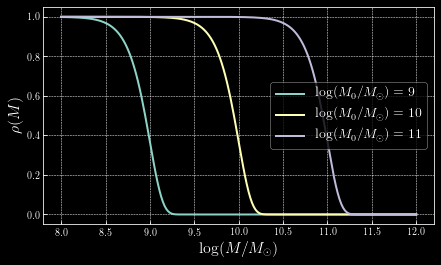

In [218]:
plt.figure(figsize=(7, 4))
for log_M0 in [9, 10, 11]:
    plt.plot(log_M_range, rho_func(10**log_M_range, 10**log_M0, 3., 1.), label=r'$\log (M_0/M_{\odot})=%s$' % log_M0)
plt.xlabel(r'$\log (M/M_{\odot})$', fontsize=16)
plt.ylabel(r'$\rho (M)$', fontsize=16)
plt.legend(fontsize=14)
# plt.savefig('nb_figures/efficiency_function.svg', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [219]:
def plot_efficiency_function(log_M0=10., beta=5., C=1.):
    plt.figure()
    plt.plot(log_M_range, rho_func(10**log_M_range, 10**log_M0, beta, C))
    plt.xlabel(r'$\log (M/M_{\odot})$', fontsize=16)
    plt.ylabel(r'$\rho (M)$', fontsize=16)
    plt.show()
    
interact(plot_efficiency_function, log_M0=(8,12,0.1), beta=(0,20,0.1), ff=(0.5,5,0.1))

A Jupyter Widget

<function __main__.plot_efficiency_function>

## Mass function SFR with $\rho(M)$

In [220]:
mass_function_SFR_efficiency = model.generate_mass_function_SFR_efficiency(
    phi_dict, rho_func, 0.2)

**Compare the function with the plot from *Shultze et al. (2017)* **
<br>
Figure 12
https://arxiv.org/pdf/1612.05978.pdf

In [221]:
weighted_SFR_plot = pd.read_table('data/sushies2_mass_bias_1_SLSN_upper.txt', header=-1)
xdata, ydata = weighted_SFR_plot.as_matrix().T

In [222]:
def plot_mass_weighted_SFR(log_M0, beta=1., C=1.):
    plt.figure()
    plt.plot(xdata, ydata*rho_func(10**xdata, 10**log_M0, beta, C))
    plt.plot(log_M_range, mass_function_SFR_efficiency(log_M_range, log_M0, beta, C), c='gray', linestyle='-')
    plt.ylim([0,1])
    plt.legend(['From Schultze et al.', 'Mass function SFR w/ efficiency'], fontsize=14)
    plt.show()
    
interact(plot_mass_weighted_SFR, log_M0=(1,30,0.5), beta=(0,10), C=(-10,10,0.1))

A Jupyter Widget

<function __main__.plot_mass_weighted_SFR>

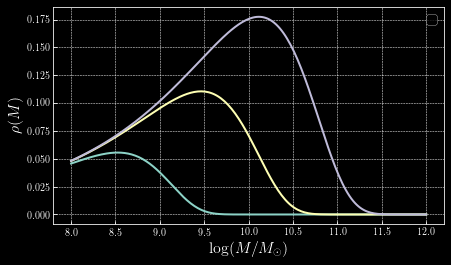

In [223]:
plt.figure(figsize=(7, 4))
for log_M0 in [9, 10, 11]:
    plt.plot(log_M_range, mass_function_SFR(log_M_range)*rho_func(log_M_range, log_M0, 25., 1.))
plt.xlabel(r'$\log (M/M_{\odot})$', fontsize=16)
plt.ylabel(r'$\rho (M)$', fontsize=16)
plt.legend(fontsize=14)
# plt.savefig('nb_figures/efficiency_function.svg', bbox_inches='tight', dpi=600, transparent=True)
plt.show()

## Fitting $M_0$ and $\beta$ in $\rho(M)$

### Fitting properties

**Parameters properties**

In [224]:
param_properties = ParamProperties(
    params=['log_M0', 'beta', 'C'], 
    bounds=[(1, 20), (0, 20), (0.5, 10)],
    latex=[r'\log (M_0/M_{\odot})', r'\beta', r'C']
)

In [225]:
fitting_cases = {
    1: {
        'func': lambda log_M, log_M0, beta, C: mass_function_SFR_efficiency(log_M, log_M0, beta, C),
        'params': ['log_M0', 'beta', 'C']
    },
    2: {
        'func': lambda log_M, log_M0, C: mass_function_SFR_efficiency(log_M, log_M0, 1., C),
        'params': ['log_M0', 'C']
    }, 
    3: {
        'func': lambda log_M, log_M0, beta: mass_function_SFR_efficiency(log_M, log_M0, beta, 1.),
        'params': ['log_M0', 'beta']
    }
}

In [226]:
def get_fitting_properties(key):
    props = fitting_cases[key]
    return props['func'], param_properties.reduced_to(props['params'])

**Choose fitting function and parameters**

In [227]:
fitting_function, fitting_param_properties = get_fitting_properties(1)

### No bootstrapping

Take the histogram as it is (no bootstrap) and fit $M_C$ and $\beta$.

In [228]:
fit_no_bootstrapping = Fitting(transient_type_dict, fitting_function, 
                               fitting_param_properties)

SNIIb     log_M0=---       beta=---       C=---       
SNIb      log_M0=---       beta=---       C=---       
SNIc      log_M0=---       beta=---       C=---       
SNII      log_M0=---       beta=---       C=---       
SNIIn     log_M0=---       beta=---       C=---       
SLSN-IIn  log_M0=1.0       beta=0.0304    C=7.22      
GRB       log_M0=11.1      beta=0.647     C=1.53      
SNIc-BL   log_M0=1.0       beta=0.019     C=5.02      
SLSN-I    log_M0=8.29      beta=0.246     C=10.0      
SNIbn     log_M0=---       beta=---       C=---       


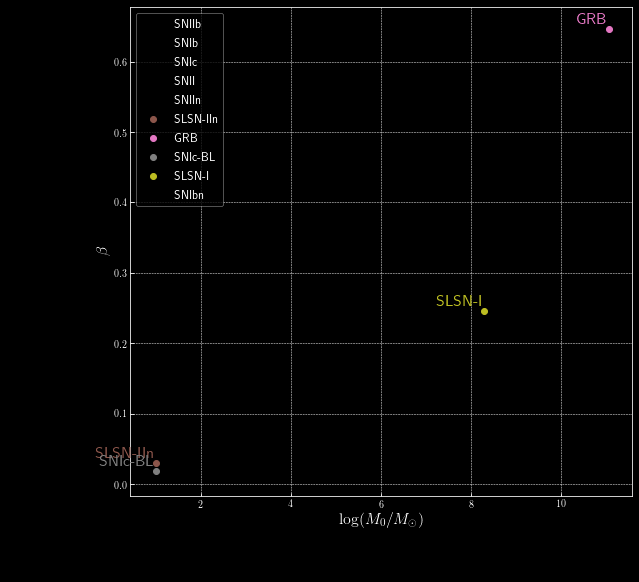

In [229]:
fit_no_bootstrapping.print_results(success_only=True)
fit_no_bootstrapping.plot_results(success_only=True)

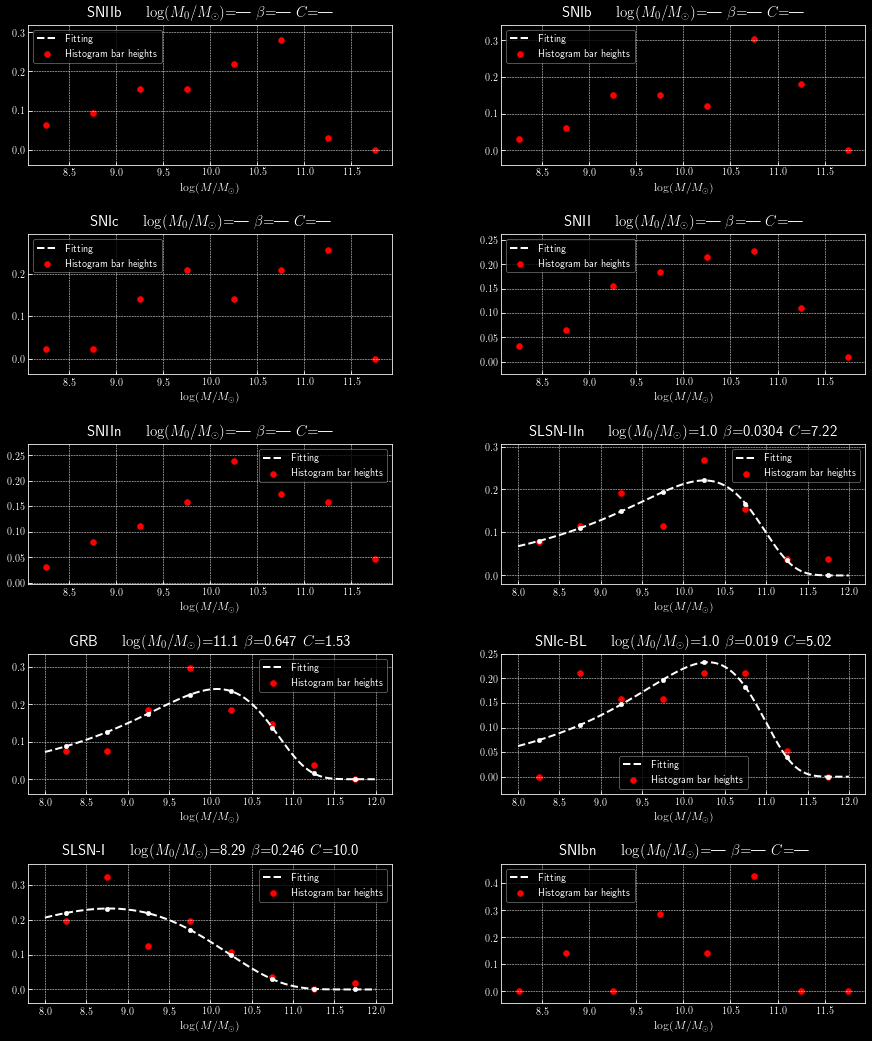

In [230]:
# save_to_file='nb_figures/no_bootstrapping_fitting.svg'
fit_no_bootstrapping.plot_fitting_functions(success_only=True)

In [231]:
{tt: r.success for tt, r in fit_no_bootstrapping.results.iteritems()}

{'GRB': 1,
 'SLSN-I': 1,
 'SLSN-IIn': 1,
 'SNII': 0,
 'SNIIb': 0,
 'SNIIn': 0,
 'SNIb': 0,
 'SNIbn': 0,
 'SNIc': 0,
 'SNIc-BL': 1}

### Bootstrapping

Generate N histograms (bootstrap) and fit $M_C$ and $\beta$, and get the distribution of the parameters.

In [232]:
number_of_samples = 1000 # N histograms

In [233]:
fit_bootstrapping = Fitting(transient_type_dict, fitting_function, 
                            fitting_param_properties, number_of_samples)

SNIIb     log_M0=4.59      beta=6.68e-05  C=3.24      
SNIb      log_M0=4.78      beta=7.84e-12  C=2.96      
SNIc      log_M0=4.87      beta=1.05e-10  C=2.82      
SNII      log_M0=5.19      beta=4.75e-11  C=3.07      
SNIIn     log_M0=5.39      beta=9.58e-11  C=2.9       
SLSN-IIn  log_M0=6.17      beta=3.13      C=4.63      
GRB       log_M0=9.79      beta=0.471     C=3.04      
SNIc-BL   log_M0=4.41      beta=0.0547    C=5.47      
SLSN-I    log_M0=9.18      beta=0.509     C=5.78      
SNIbn     log_M0=3.99      beta=0.0238    C=3.2       


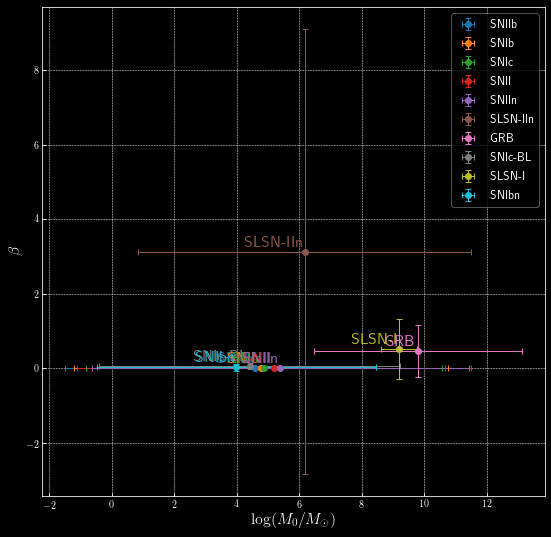

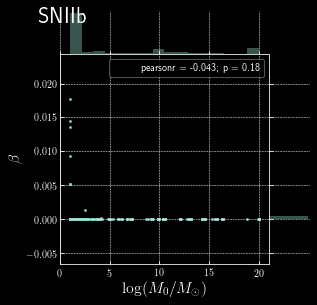

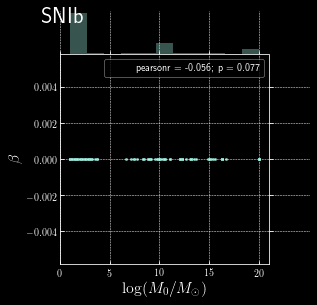

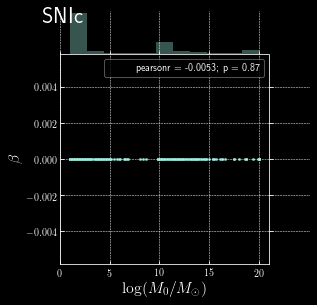

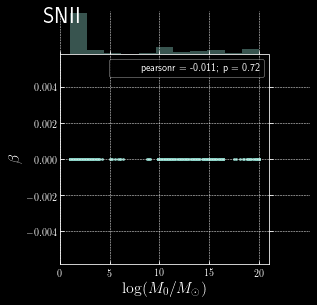

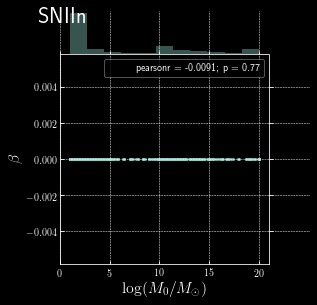

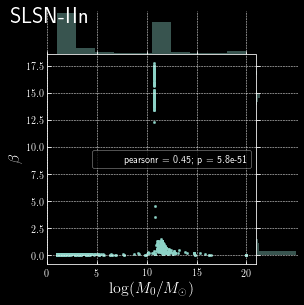

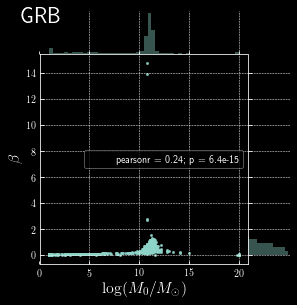

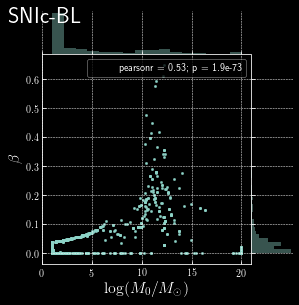

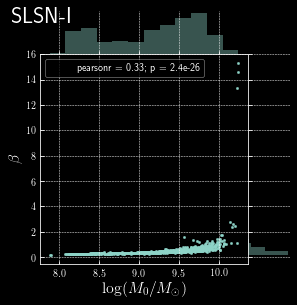

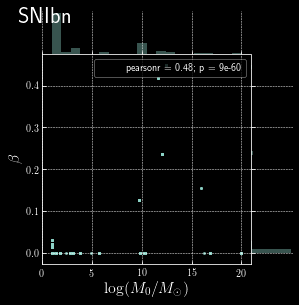

In [234]:
fit_bootstrapping.print_results()
fit_bootstrapping.plot_results()
fit_bootstrapping.plot_M0_and_beta_distributions()

In [235]:
{tt: r.success for tt, r in fit_bootstrapping.results.iteritems()}

{'GRB': 972,
 'SLSN-I': 1000,
 'SLSN-IIn': 924,
 'SNII': 5,
 'SNIIb': 16,
 'SNIIn': 16,
 'SNIb': 42,
 'SNIbn': 120,
 'SNIc': 24,
 'SNIc-BL': 805}

### Bootstrapping with random bin centers

Generate N histograms where the position of the bars is different in each sample, and do the fitting (like previous case).

In [236]:
number_of_samples = 1000 # N histograms

In [237]:
fit_bootstrapping_rand_bins = Fitting(transient_type_dict, fitting_function, 
                                      fitting_param_properties, 
                                      number_of_samples, random_bin_centers=True)

SNIIb     log_M0=4.77      beta=0.716     C=3.39      
SNIb      log_M0=4.74      beta=7.95e-12  C=3.2       
SNIc      log_M0=4.02      beta=7.81e-12  C=3.32      
SNII      log_M0=3.08      beta=1.44e-11  C=3.33      
SNIIn     log_M0=5.07      beta=3.25e-11  C=3.32      
SLSN-IIn  log_M0=8.22      beta=4.9       C=3.71      
GRB       log_M0=9.87      beta=1.49      C=2.98      
SNIc-BL   log_M0=4.16      beta=0.0604    C=7.18      
SLSN-I    log_M0=9.16      beta=0.647     C=6.71      
SNIbn     log_M0=4.4       beta=0.0383    C=3.36      


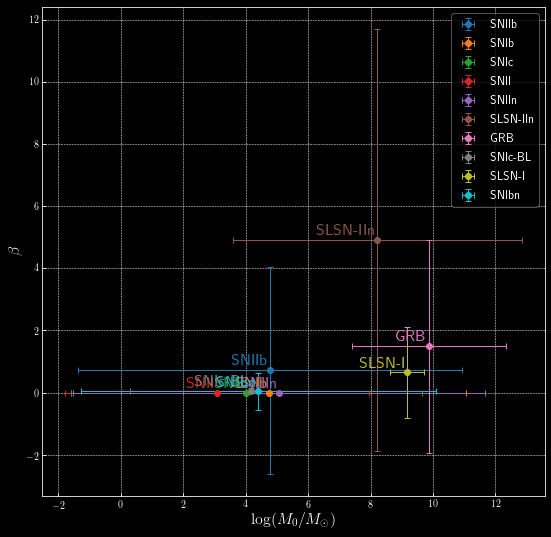

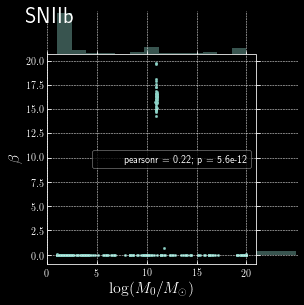

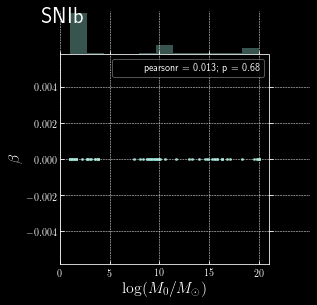

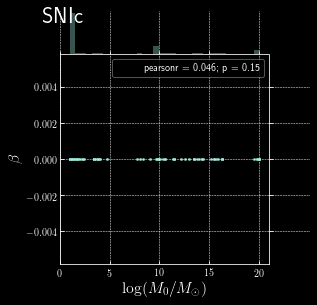

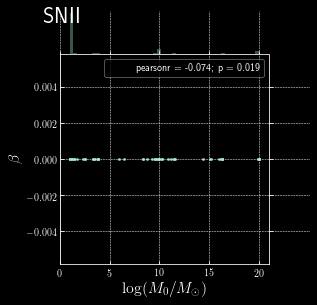

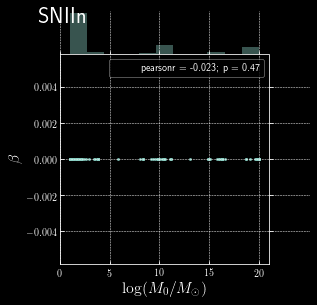

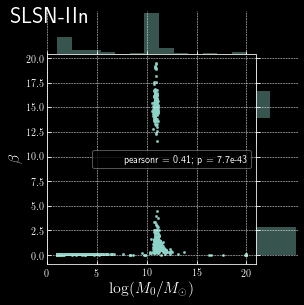

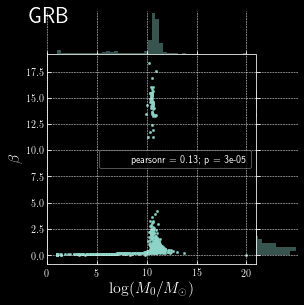

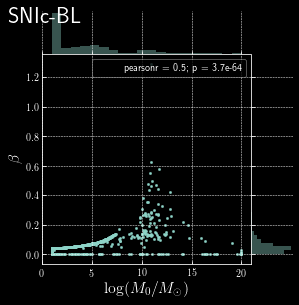

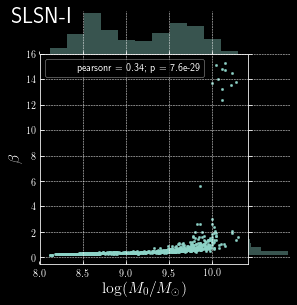

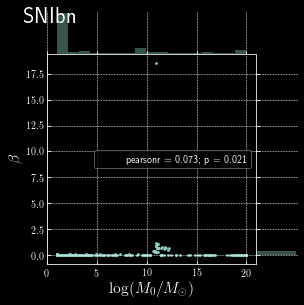

In [238]:
fit_bootstrapping_rand_bins.print_results()
fit_bootstrapping_rand_bins.plot_results()
fit_bootstrapping_rand_bins.plot_M0_and_beta_distributions()

(array([ 991.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    9.]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.]),
 <a list of 30 Patch objects>)

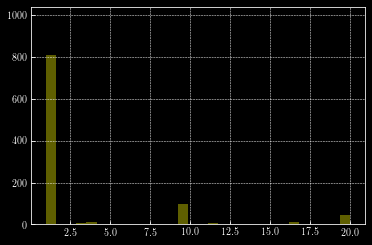

In [239]:
r = fit_bootstrapping_rand_bins.results['SNII']
np.count_nonzero(np.array(r.success)) / float(len(r.success_arr))
plt.hist(r['log_M0'], bins=30, normed=False, alpha=0.5, color='y')
plt.hist(r['log_M0'][np.array(r.success_arr)], bins=30, normed=False, alpha=0.5, color='r')

In [240]:
{tt: np.count_nonzero(r.success_arr) / float(len(r.success_arr)) for tt, r in fit_bootstrapping_rand_bins.results.iteritems()}


{'GRB': 0.985,
 'SLSN-I': 1.0,
 'SLSN-IIn': 0.935,
 'SNII': 0.009,
 'SNIIb': 0.12,
 'SNIIn': 0.011,
 'SNIb': 0.015,
 'SNIbn': 0.098,
 'SNIc': 0.016,
 'SNIc-BL': 0.864}

#### Consider only successful fitting results

SNIIb     log_M0=7.28      beta=5.96      C=2.97      
SNIb      log_M0=4.52      beta=1.79e-17  C=3.14      
SNIc      log_M0=4.48      beta=1.43e-17  C=3.21      
SNII      log_M0=1.0       beta=1.21e-17  C=3.32      
SNIIn     log_M0=4.08      beta=8.7e-18   C=3.26      
SLSN-IIn  log_M0=8.51      beta=5.24      C=3.72      
GRB       log_M0=9.98      beta=1.51      C=2.97      
SNIc-BL   log_M0=4.03      beta=0.0699    C=7.81      
SLSN-I    log_M0=9.16      beta=0.647     C=6.71      
SNIbn     log_M0=6.24      beta=0.391     C=3.73      


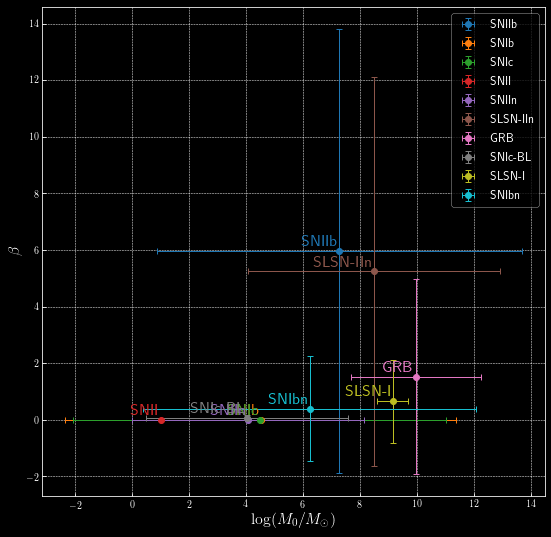

In [241]:
fit_bootstrapping_rand_bins.print_results(success_only=True)
fit_bootstrapping_rand_bins.plot_results(success_only=True)
# fit_bootstrapping_rand_bins.plot_results(save_to_file='nb_figures/fitting_results.svg', success_only=True)

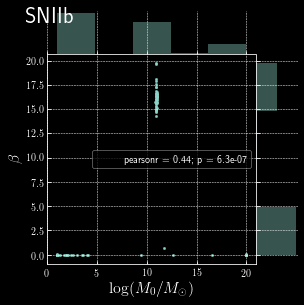

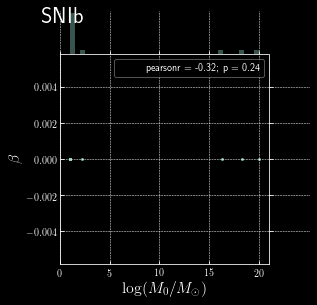

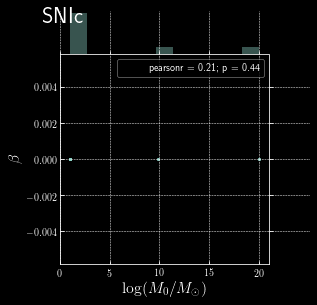

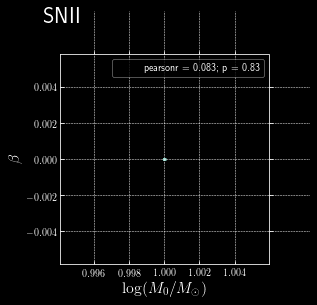

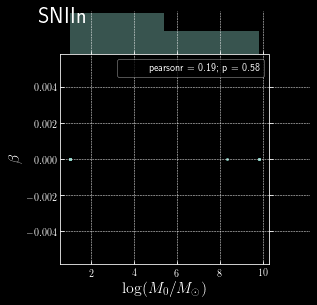

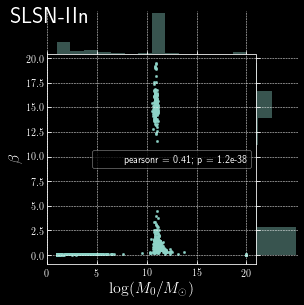

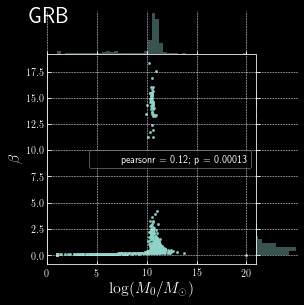

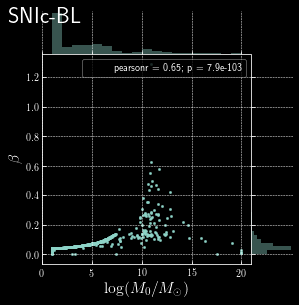

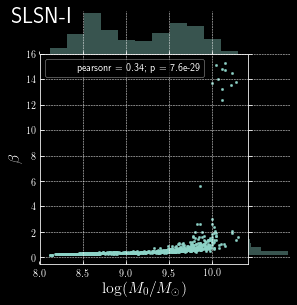

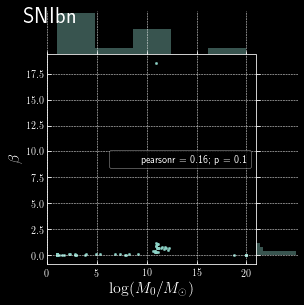

In [257]:
# fit_bootstrapping_rand_bins.plot_M0_and_beta_distributions(success_only=True)
fit_bootstrapping_rand_bins.plot_M0_and_beta_distributions(save_to_dir='nb_figures/dists', success_only=True)

### Comparing

In [243]:
fitting_instances = [
    fit_no_bootstrapping, 
    fit_bootstrapping, 
    fit_bootstrapping_rand_bins
]

descriptions = [
    'No bootstrapping',
    'Bootstrapping (%s samples)' % fit_bootstrapping.number_of_samples,
    'Bootstrapping - random bin centers (%s samples)' % fit_bootstrapping_rand_bins.number_of_samples
]

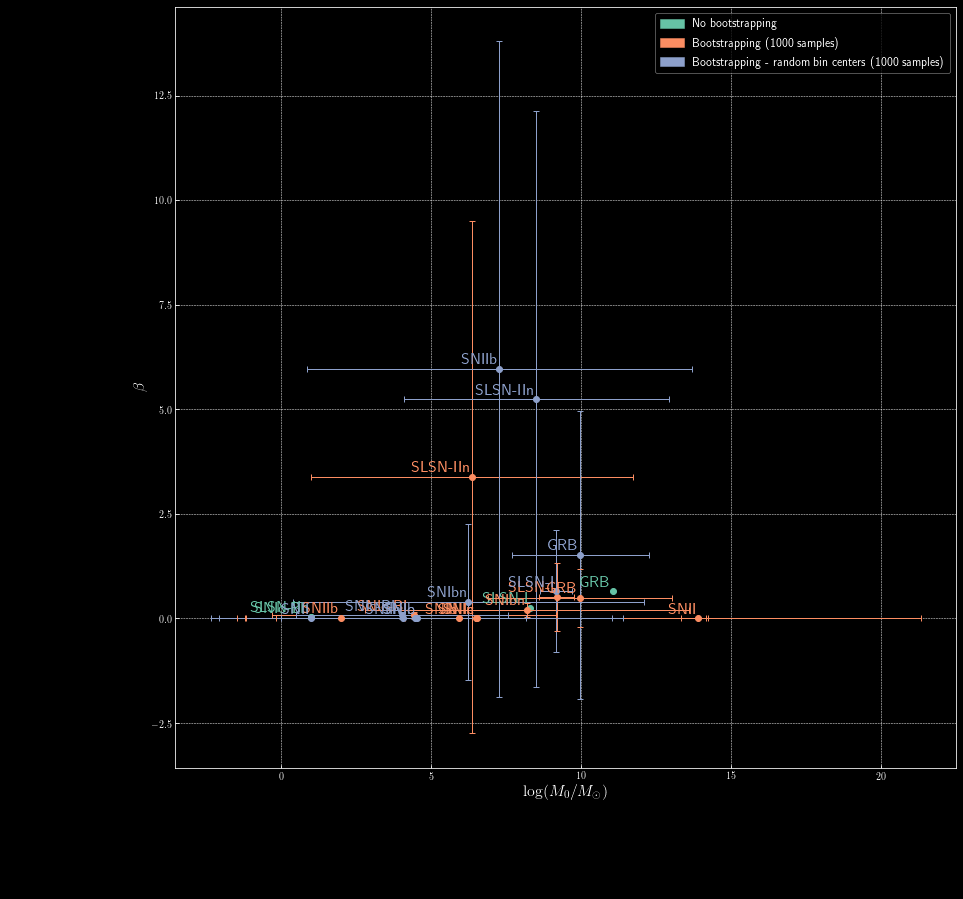

In [244]:
Fitting.plot_comparison(fitting_instances, descriptions, cmap='Set2', success_only=True)

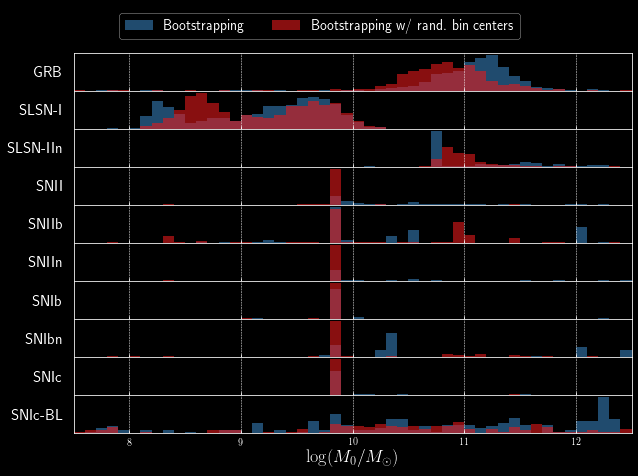

In [245]:
Fitting.plot_M0_histograms(['Bootstrapping', 'Bootstrapping w/ rand. bin centers'],
                           [fit_bootstrapping, fit_bootstrapping_rand_bins],
                           success_only=False)

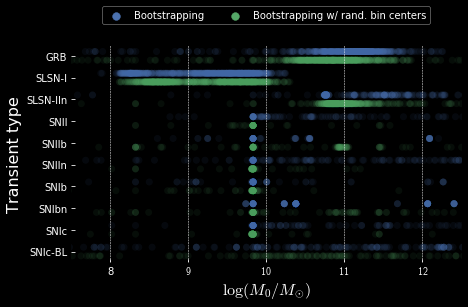

In [246]:
Fitting.plot_stripplot(['Bootstrapping', 'Bootstrapping w/ rand. bin centers'], 
                       [fit_bootstrapping, fit_bootstrapping_rand_bins])

#### Consider only successful fitting results

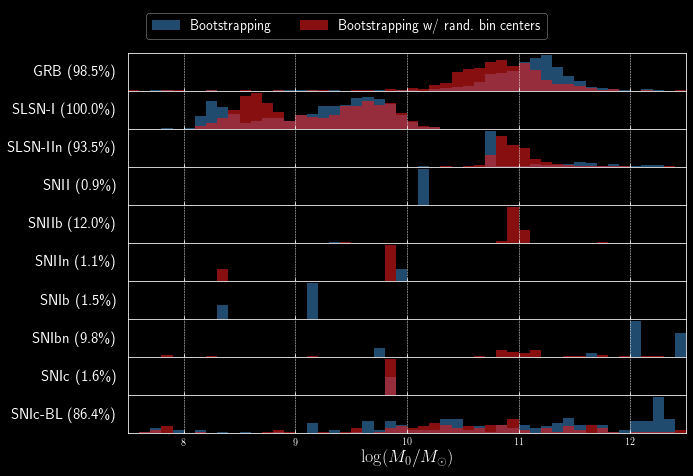

In [258]:
Fitting.plot_M0_histograms(['Bootstrapping', 'Bootstrapping w/ rand. bin centers'],
                           [fit_bootstrapping, fit_bootstrapping_rand_bins],
                           save_to_file='nb_figures/M0_histograms.svg', 
                           success_only=True)

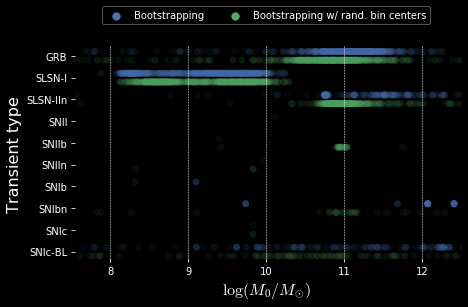

In [259]:
Fitting.plot_stripplot(['Bootstrapping', 'Bootstrapping w/ rand. bin centers'], 
                       [fit_bootstrapping, fit_bootstrapping_rand_bins], 
                       save_to_file='nb_figures/M0_distributions.svg', 
                      success_only=True)

In [110]:
# fit_bootstrapping_rand_bins.results['SNIc-BL']['log_M0'][fit_bootstrapping_rand_bins.results['SNIc-BL'].get_success_bitmap()]

**Plot the parameters of the fitting results**

In [66]:
tt = 'SLSN-I'
log_M0_mean = np.mean(fit_bootstrapping_rand_bins.results[tt]['log_M0'])
beta_mean = np.mean(fit_bootstrapping_rand_bins.results[tt]['beta'])
C_mean = np.mean(fit_bootstrapping_rand_bins.results[tt]['C'])
log_M0_mean, beta_mean, C_mean

(9.1295504233015876, 0.648428120093829, 6.8939927348421302)

In [67]:
df = transient_type_dict['SLSN-I']
bin_centers, bin_heights = fitting.calculate_bin_coordinates(df.mass)

In [68]:
def plot_mass_function_SFR_efficiency(log_M0=10., beta=1., C=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.scatter(bin_centers, bin_heights)
    ax1.plot(log_M_range, mass_function_SFR(log_M_range), c='gray', linestyle='--')
    ax1.plot(log_M_range, mass_function_SFR_efficiency(log_M_range, log_M0, beta, C), c='w')
    ax1.plot(log_M_range, mass_function_SFR_efficiency(log_M_range, log_M0_mean, beta_mean, C_mean), c='green')
#     ax1.legend(['Mass function', r'Mass function with $\rho(M)$', 'SLSN-I hist.'])

    #     ax1.set_ylim([0,0.2])
    ax2.set_title(r'$\rho(M)$')
    ax2.plot(log_M_range, rho_func(10**log_M_range, 10**log_M0, beta, C))
    ax2.scatter(bin_centers, rho_func(10**bin_centers, 10**log_M0, beta, C))

interact(plot_mass_function_SFR_efficiency, log_M0=(5,20,0.25), beta=(0,10,0.1), C=(0.5,20))

A Jupyter Widget

<function __main__.plot_mass_function_SFR_efficiency>

---

# _temp

In [1450]:
g = fitting.create_group_by_object_sampled(transient_type_dict['SLSN-IIn'], number_of_samples)

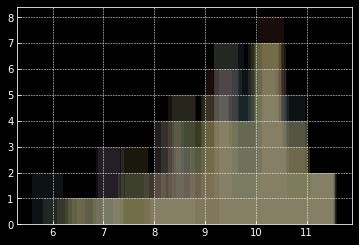

In [1451]:
plt.figure()
means = []
m_arrays = []
for i in range(10):
    m_arr = g.apply(lambda g: g.iat[i])
    plt.hist(m_arr, alpha=.1)
    m_arrays += list(m_arr)
    means.append(m_arr.mean())
plt.show()